# Tutorial

The `flacarray` package has tools for working with compressed arrays in memory, as well as saving and loading those to several file formats.  This tutorial makes use of some interactive helper functions in the `flacarray.demo` package.

In [1]:
import numpy as np
import h5py # For optional I/O operations
import zarr # For optional I/O operations

## `FlacArray` - Compressed Arrays in Memory

The primary class for working with compressed arrays in memory is the `FlacArray` class.  You can construct one of these from a numpy array with a class method.  First create some fake data in a numpy array for testing.  This is a small 3-D array and the final dimension is always the one that is compressed.  This last dimension should consist of "streams" of data.

In [2]:
from flacarray import FlacArray, demo

In [3]:
# Create a 3D array where the last dimension is the "streams" we are compressing.
arr = demo.create_fake_data((4, 3, 10000))
# How large is this in memory?
print(f"Input array is {arr.nbytes} bytes")

Input array is 960000 bytes


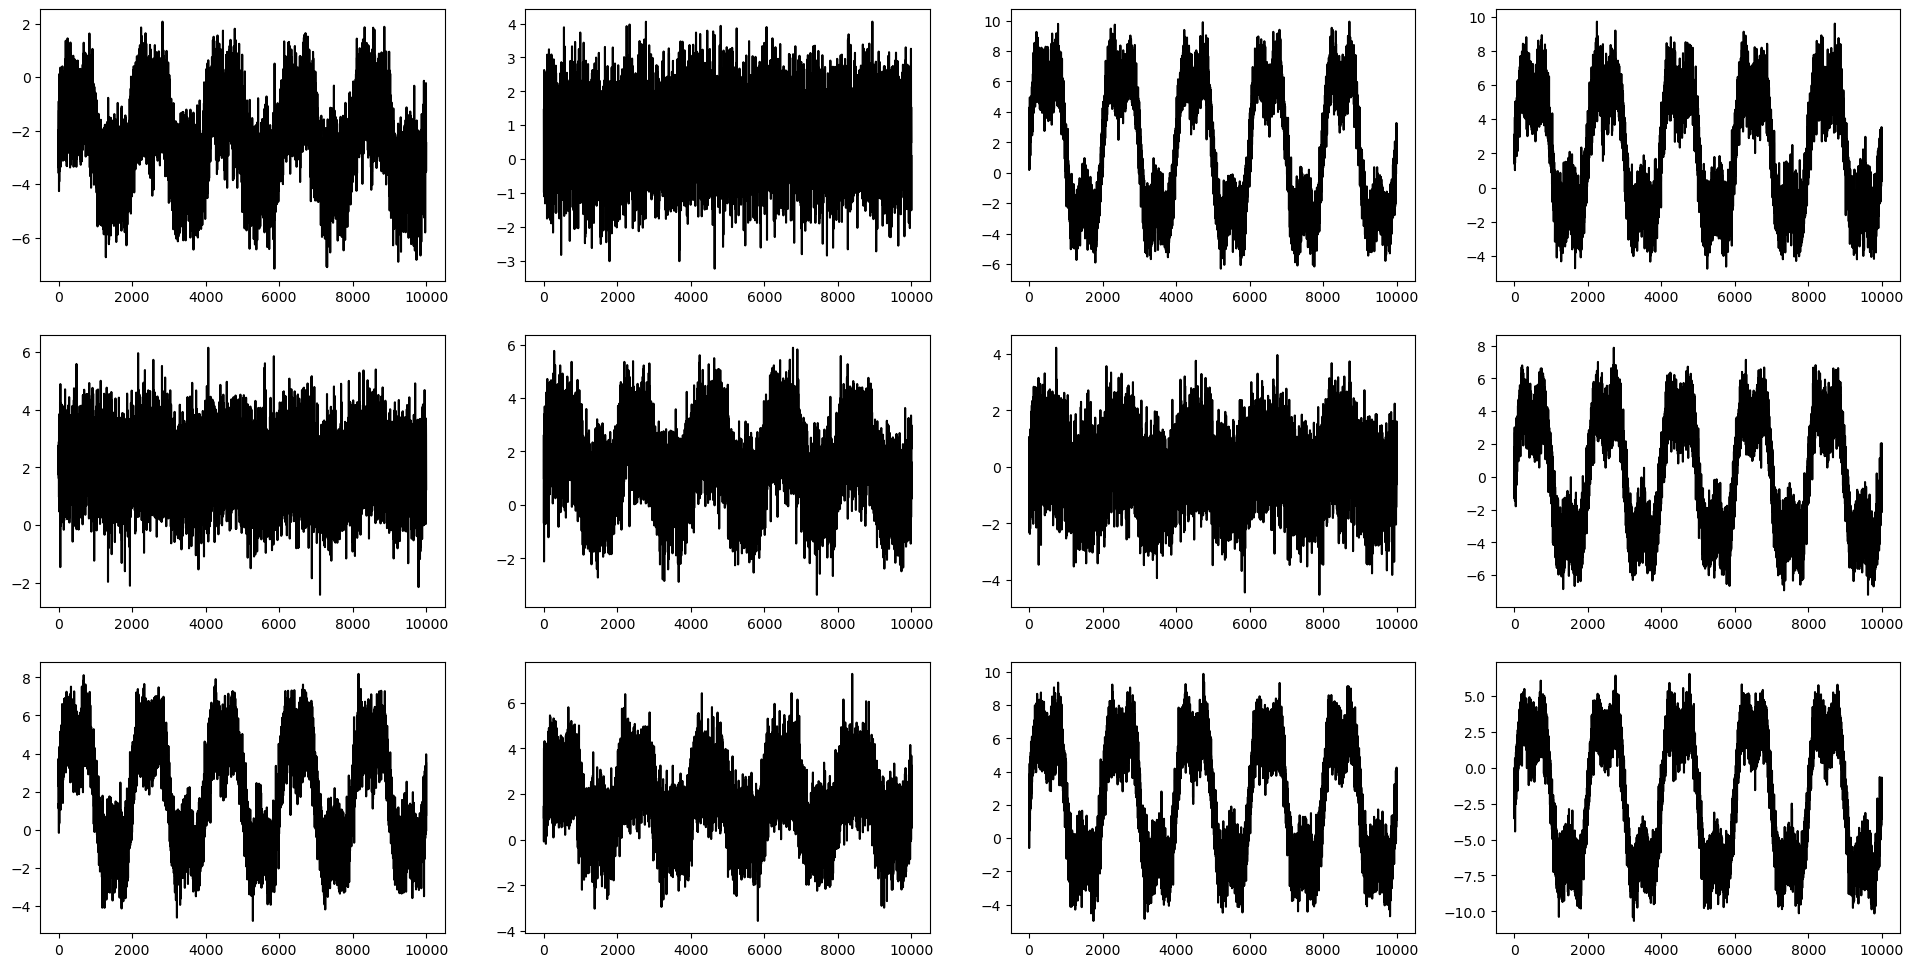

In [4]:
# Plot these streams
demo.plot_data(arr)

### Create From Array

Now create a `FlacArray` from this.  Since this is floating point data, the streams will always be truncated to 32 bits and by default each bit value will be chosen so that the peak-to-peak range of the signal spans the available $2^{30}$ bits available for the FLAC stream.

In [5]:
# Create a compressed array
flcarr = FlacArray.from_array(arr)

In [6]:
# Properties of the compressed array
print(flcarr)

<FlacArray float64 shape=(4, 3, 10000) bytes=447080>


### Decompress Back to Array

Now decompress back to a numpy array.  The results will only be bitwise identical for arrays consisting of 32 bit integers.

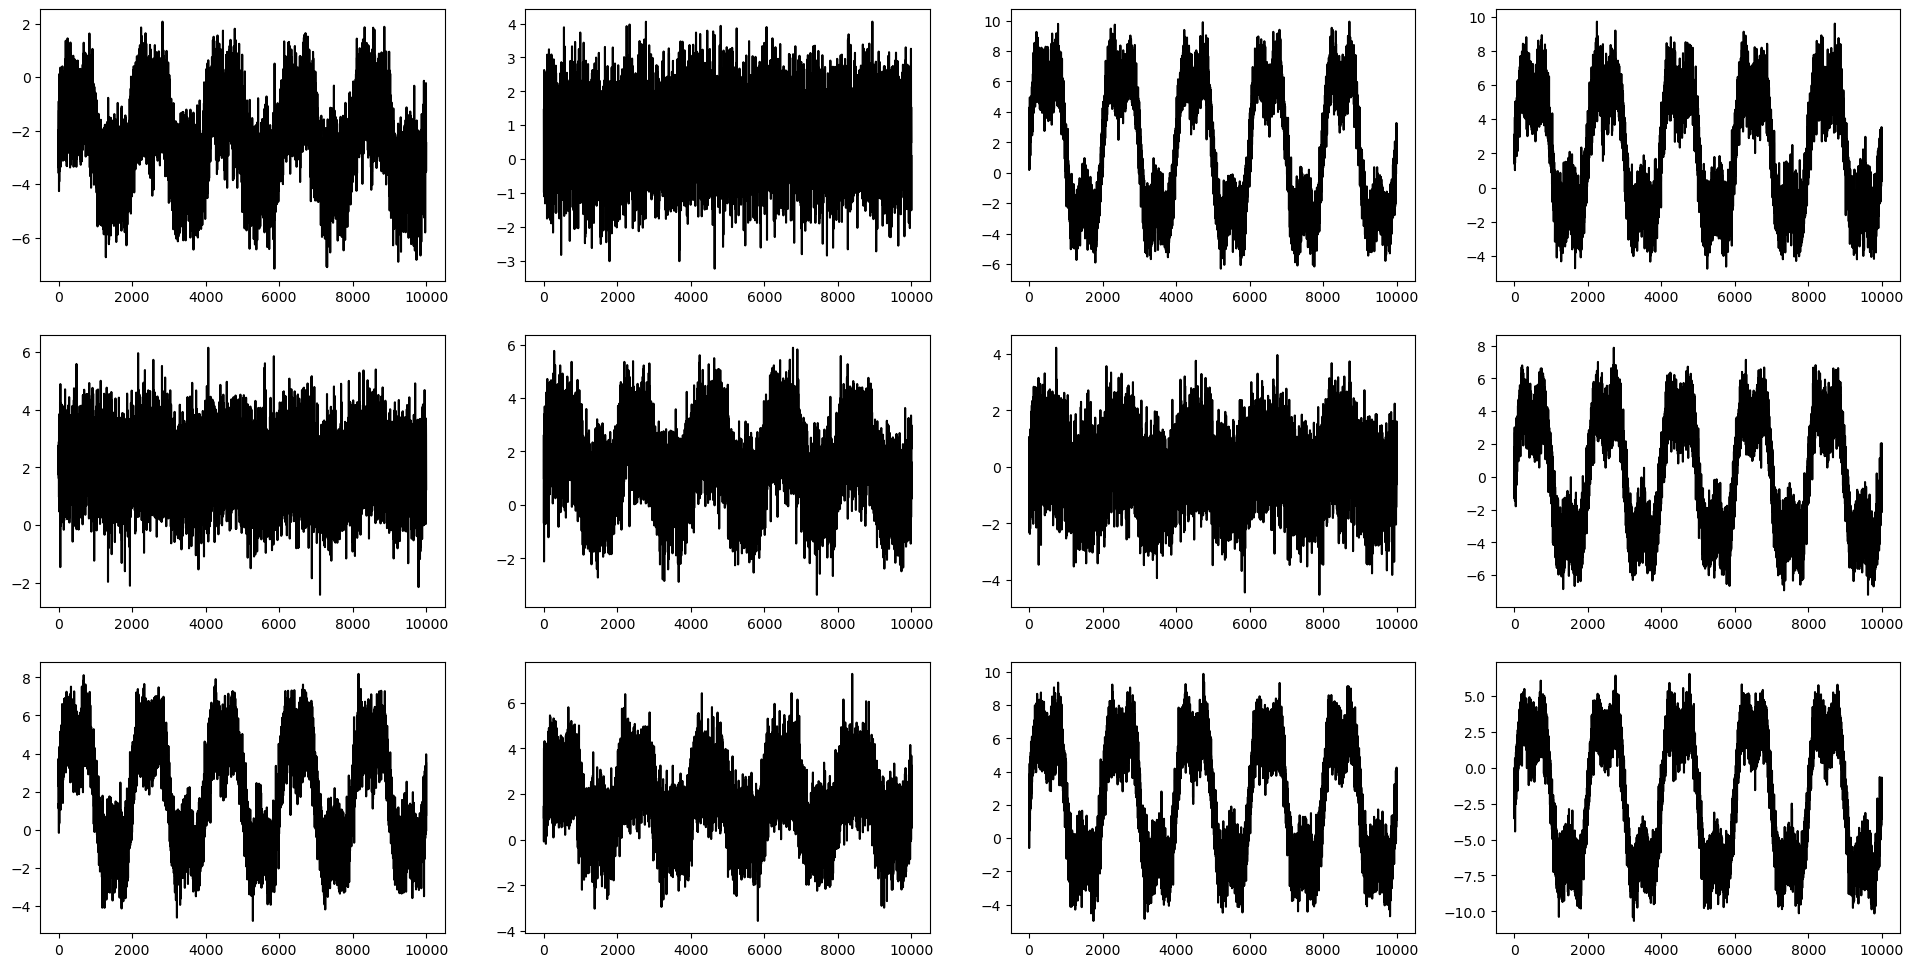

In [7]:
# Restore back to an array
restored = flcarr.to_array()
demo.plot_data(restored)

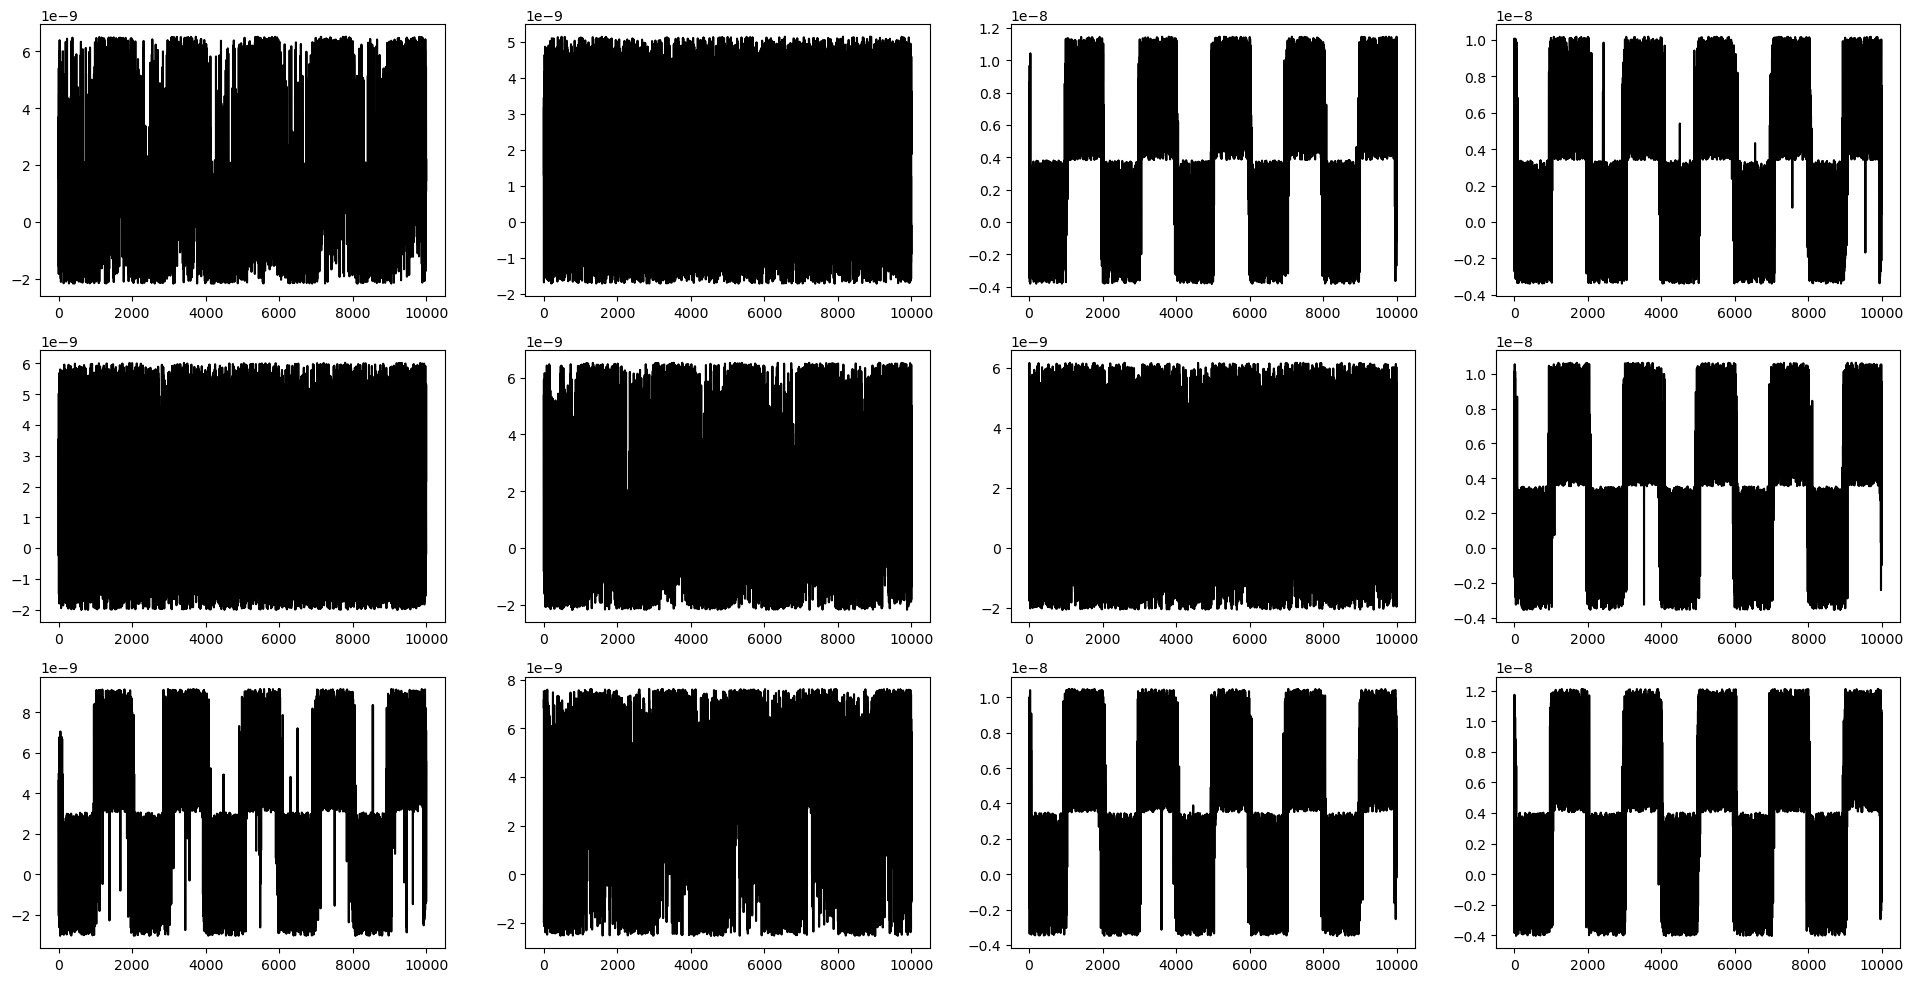

In [8]:
# Plot the residual
residual = restored - arr
demo.plot_data(residual)

### Slicing

A subset of the full array can be decompressed on the fly.  Any fancy array indexing can be used for the leading dimensions, but only contiguous slices or individual samples are supported in the last dimension.

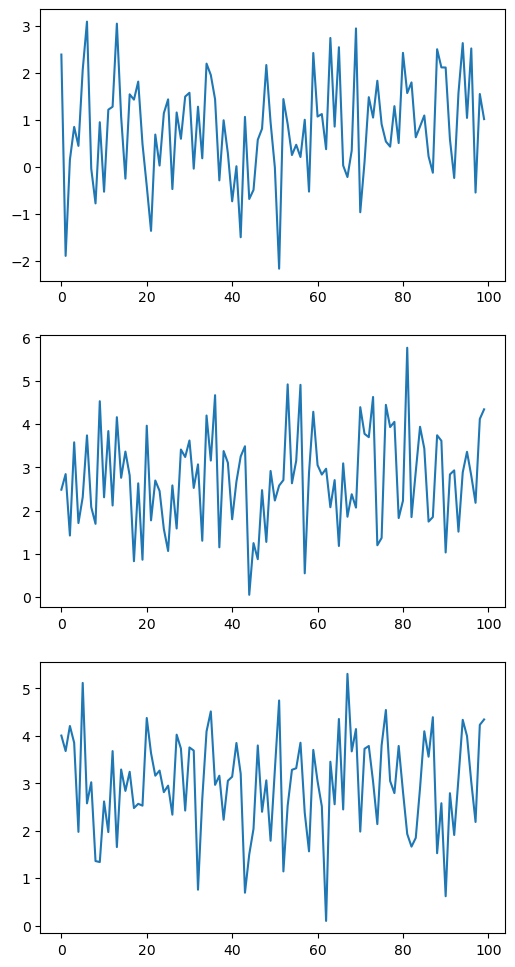

In [9]:
subarr = flcarr[1:2, :, 200:300]
demo.plot_data(subarr)

### Writing and Reading

The `FlacArray` class has methods to write the internal compressed data and metadata to both h5py and zarr groups.  The data members written to these file formats are simple arrays and scalars.  Supporting other formats in the future would be straightforward.  When decompressing data from disk, you can choose to decompress only a subset of the streams.  Here is an example writing the compressed array to HDF5 and loading it back in.

In [10]:
with h5py.File("flcarr.h5", "w") as hf:
    flcarr.write_hdf5(hf)

In [11]:
# We can load this back into a new FlacArray using a class method
with h5py.File("flcarr.h5", "r") as hf:
    new_flcarr = FlacArray.read_hdf5(hf)

In [12]:
# The compressed representations should be equal...
print(new_flcarr == flcarr)

True


You can also load in just a subset of the streams using a "keep" mask.  This is a boolean array with the same shape as the leading dimensions of the original array.

In [13]:
leading_shape = arr.shape[:-1]
keep = np.zeros(leading_shape, dtype=bool)
# Select the first and last stream on the second row
keep[1, 0] = True
keep[1, -1] = True

In [14]:
# Load just these streams
with h5py.File("flcarr.h5", "r") as hf:
    sub_flcarr = FlacArray.read_hdf5(hf, keep=keep)

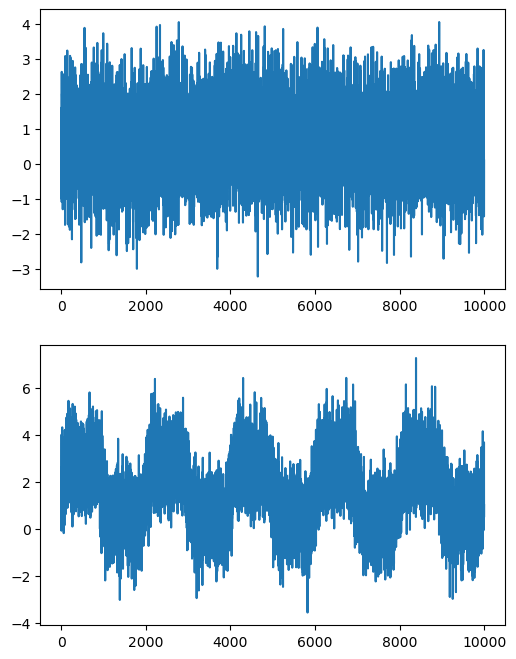

In [15]:
# Decompress and plot
demo.plot_data(sub_flcarr.to_array())

## Direct I/O and Compression of Numpy Arrays

For some use cases, there is no need to keep the full compressed data in memory (in a `FlacArray`).  Instead, a normal numpy array is compressed when writing to a file and decompressed back into a numpy array when reading.  The package has high-level functions for performing this kind of operation.  When decompressing, a subset of streams can be loaded from disk, and then a sample range can be specified when doing the decompression.

### HDF5

The `hdf5` sub-module has helper functions for direct I/O to HDF5.

In [16]:
import flacarray.hdf5

In [17]:
# Write a numpy array directly to HDF5.  This is equivalent to doing:
#
# temp = FlacArray.from_array(arr)
# with h5py.File("test.h5", "w") as hf:
#     temp.write_hdf5(hf)
#
with h5py.File("test.h5", "w") as hf:
    flacarray.hdf5.write_array(arr, hf)

In [18]:
with h5py.File("test.h5", "r") as hf:
    restored = flacarray.hdf5.read_array(hf)

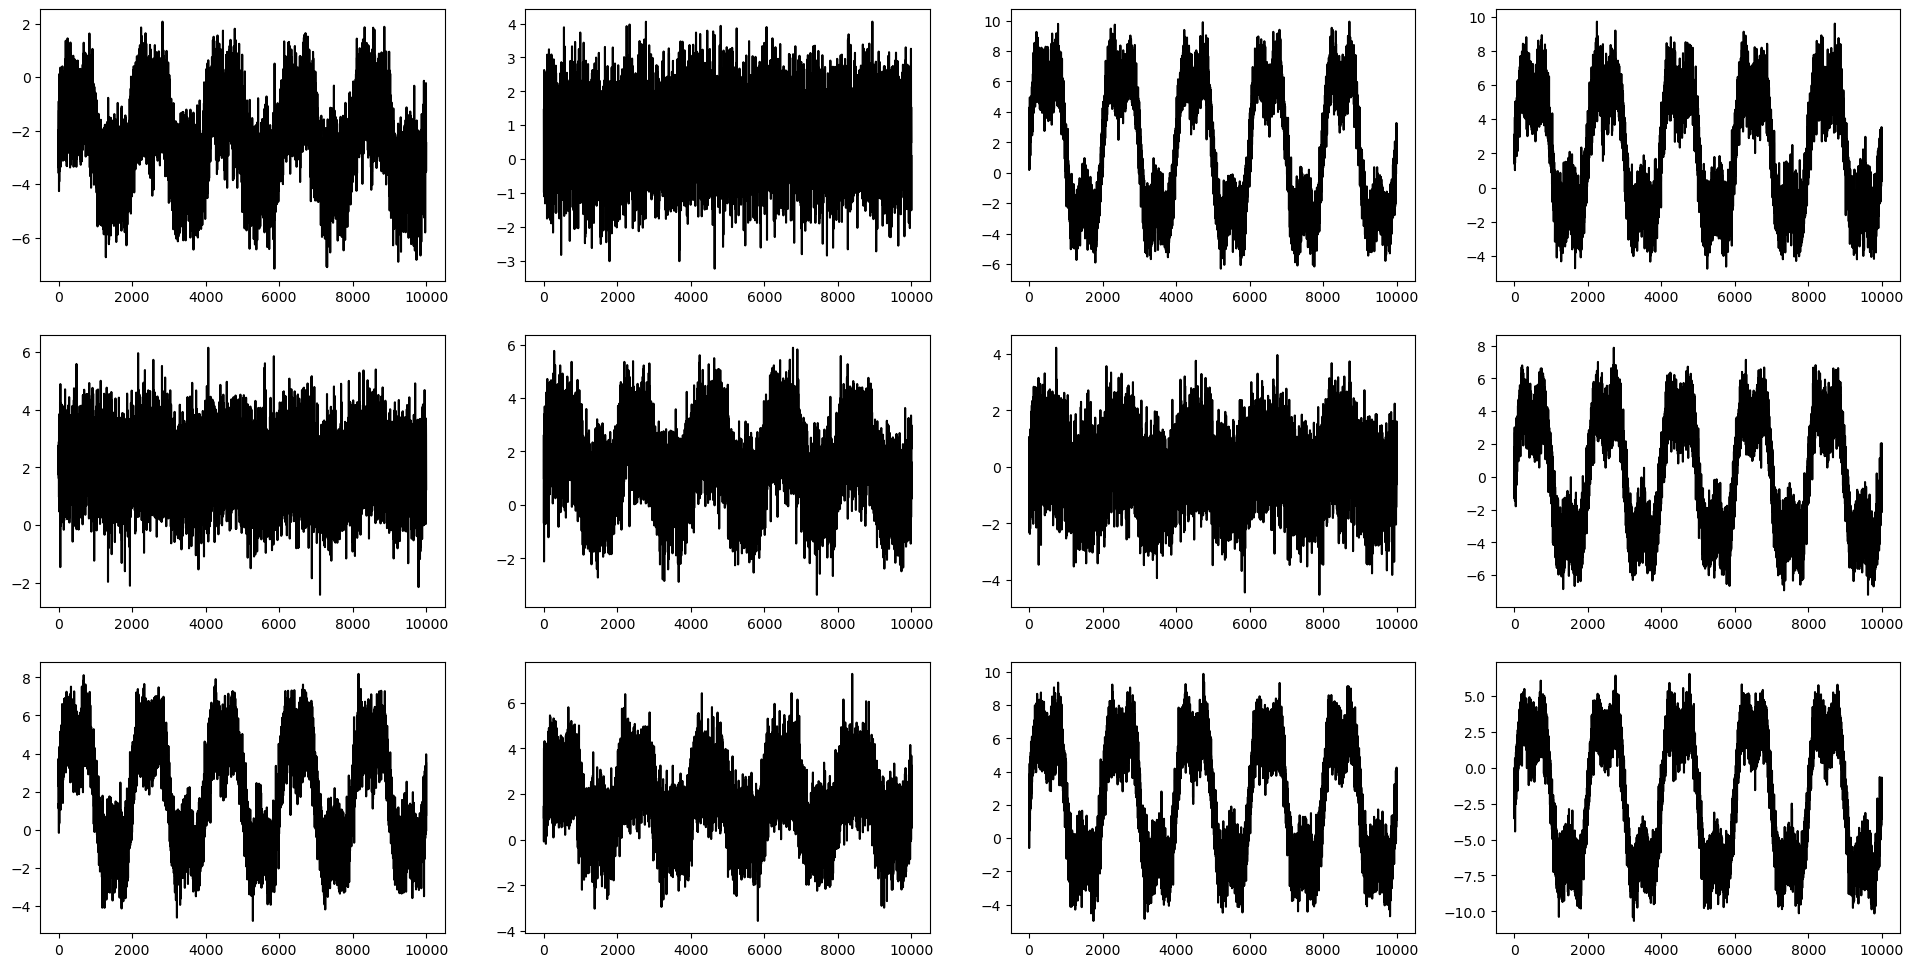

In [19]:
demo.plot_data(restored)

In [20]:
# Load only a subset of streams and a slice of samples in those streams.
# This is equivalent to the following code:
#
# with h5py.File("test.h5", "r") as hf:
#    restored = FlacArray.read_hdf5(hf, keep=keep)
#    sub_restored = restored[:, 200:300]
#
with h5py.File("test.h5", "r") as hf:
    sub_restored = flacarray.hdf5.read_array(hf, keep=keep, stream_slice=slice(200, 300, 1))

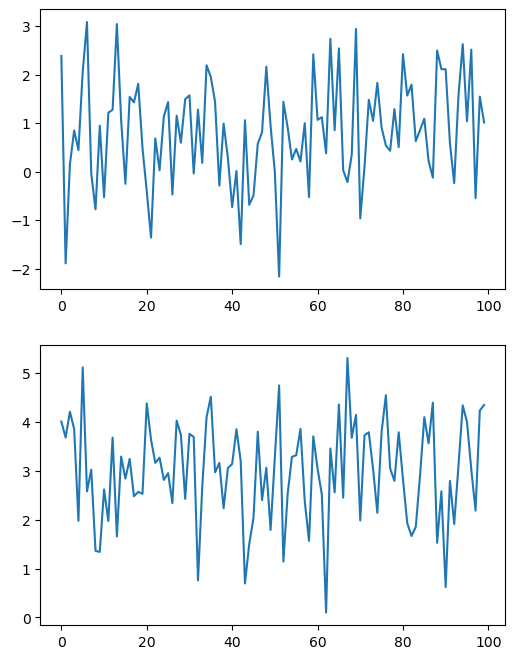

In [21]:
demo.plot_data(sub_restored)

### Zarr

The zarr package provides an h5py-like interface for creating groups with attributes and "datasets" (arrays) on disk.  Given an existing `zarr.hierarchy.Group`, you can compress and write an array and then load it back in.  This is almost identical to the HDF5 syntax above.

In [22]:
import flacarray.zarr

In [23]:
with zarr.open_group("test.zarr", mode="w") as zf:
    flacarray.zarr.write_array(arr, zf)

In [24]:
with zarr.open_group("test.zarr", mode="r") as zf:
    restored = flacarray.zarr.read_array(zf)

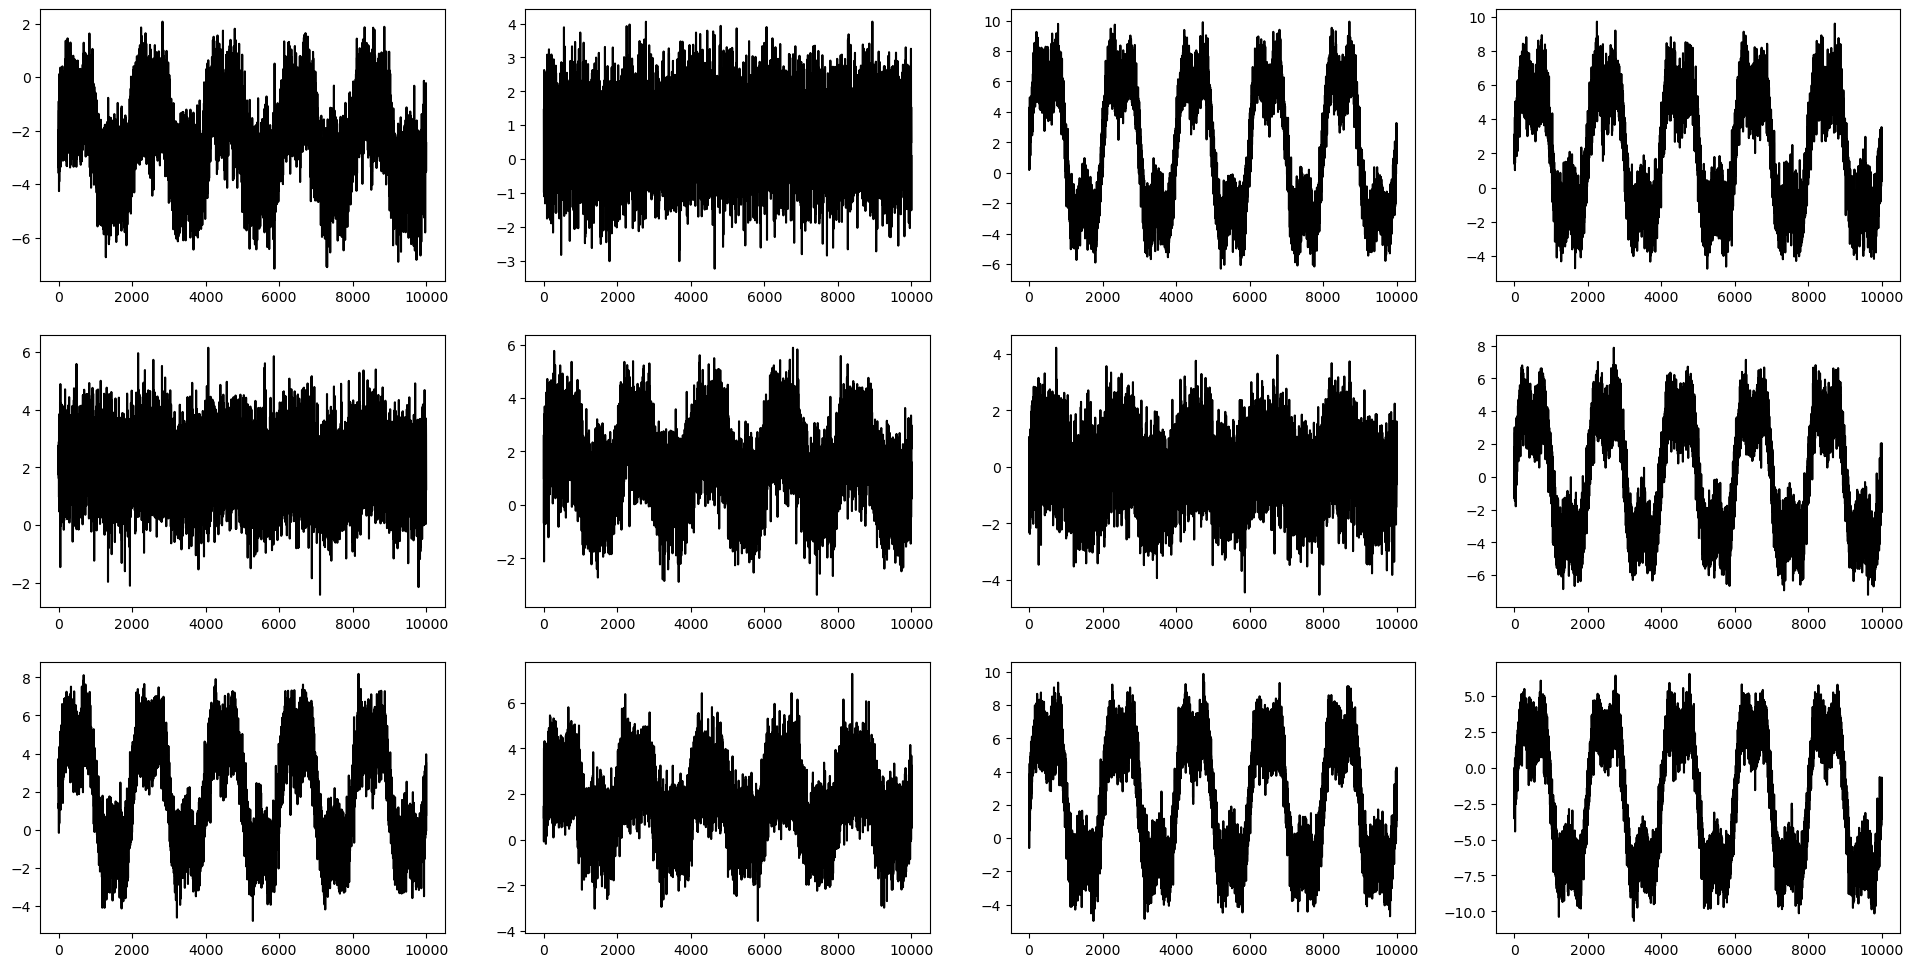

In [25]:
demo.plot_data(restored)

In [26]:
# Specifying a keep mask and sample slice also works.
with zarr.open_group("test.zarr", mode="r") as zf:
    sub_restored = flacarray.zarr.read_array(zf, keep=keep, stream_slice=slice(200, 300, 1))

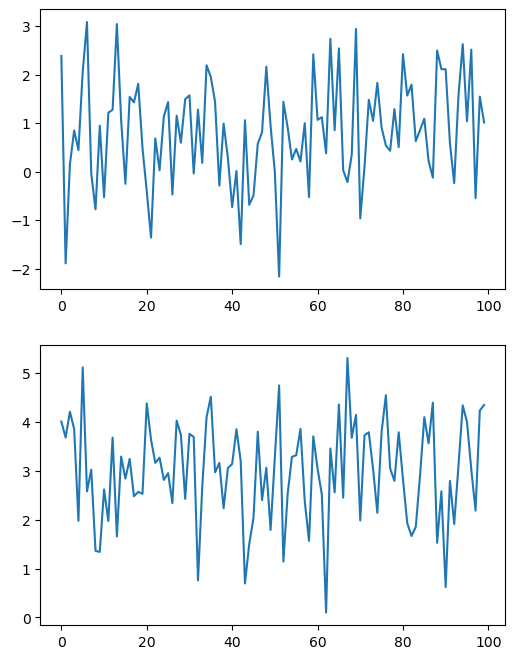

In [27]:
demo.plot_data(sub_restored)